In [1]:
# !pip install graphviz sortedcollections

In [2]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

In [3]:
u = 'w'
V = OrderedSet(sorted('wxyz'))
edges = {
    ('w', 'x'): 1,
    ('w', 'y'): 2,
    ('x', 'z'): 2,
    ('y', 'z'): 1,
}

# u = 'a'
# V = OrderedSet(sorted('abcde'))
# edges = {
#     ('a', 'b'): 2,
#     ('a', 'c'): 1,
#     ('b', 'e'): 1,
#     ('b', 'd'): 4,
#     ('d', 'c'): 8,
#     ('c', 'e'): 6,
#     ('d', 'e'): 1
# }

# u = 'u'
# V = OrderedSet(sorted('uvwxyz'))
# edges = {
#     ('u', 'w'): 5,
#     ('u', 'v'): 2,
#     ('u', 'x'): 1,
#     ('v', 'x'): 2,
#     ('v', 'w'): 3,
#     ('x', 'w'): 3,
#     ('x', 'y'): 1,
#     ('w', 'z'): 5,
#     ('w', 'y'): 1,
#     ('y', 'z'): 2,
# }

In [4]:
# Modified from \ref{https://stackoverflow.com/questions/1456373/two-way-reverse-map}
class BiDict(OrderedDict):
    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)
        
    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

E = BiDict(**edges)

In [13]:
# Lookup table containing the dist/cost from every node to every other node
# Zero if same node and infinity if nodes aren't neighbors
lookup = OrderedDict({
    u: OrderedDict({
        v: E.get((u, v), 0 if u == v else np.inf)
        for v in V})
    for u in V
})

OrderedDict([('w', OrderedDict([('w', 0), ('x', 1), ('y', 2), ('z', inf)])),
             ('x', OrderedDict([('w', 1), ('x', 0), ('y', inf), ('z', 2)])),
             ('y', OrderedDict([('w', 2), ('x', inf), ('y', 0), ('z', 1)])),
             ('z', OrderedDict([('w', inf), ('x', 2), ('y', 1), ('z', 0)]))])

In [6]:
class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist
        self.prev = prev

    def __repr__(self):
        return self.value

    def __str__(self):
        return f"{self.dist},{self.prev!r}" if self.dist != np.inf else str(np.inf)

    def __getitem__(self, q):
        """Returns the dist from p to q if neighbors; otherwise, infinity"""
        return lookup[self.value][q.value]

In [7]:
init = Node(value=u)
init.prev = init

graph = OrderedSet(map(lambda v: Node(value=v, dist=lookup[u][v], prev=init), V - set(u)))
visited = OrderedSet({init})

path = set()

In [8]:
headers = [(f"D({v!r}),p({v!r})", [str(v)]) for v in visited | graph]
table = OrderedDict([("N'", [u]), *headers])

In [9]:
for _ in range(1, len(V)):
    # NOTE: Python's min() function always selects the first occurrence if values are equal
    # So, if the algorithm encounters two paths from p to q with the same dist/cost,
    # q's prev won't change; thus, the route/path from p to q won't change either
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.prev.value, p.value))
    
    table["N'"].append(''.join(map(repr, visited)))

    for q in graph-visited:
        print(f"D({q!r}) = min(D({q!r}), D({p!r}) + C({p!r}, {q!r})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        # NOTE: if the algorithm finds another path from p to q with the same dist/cost,
        # it will change paths/routes (aka, change parents)
        if p.dist + p[q] <= q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q!r}),p({q!r})"].append(str(q))

for entry in table.values():
    entry.extend(['---'] * (len(V) - len(entry)))

D(y) = min(D(y), D(x) + C(x, y)) = min(2, 1 + inf) = min(2, inf) = 2
D(z) = min(D(z), D(x) + C(x, z)) = min(inf, 1 + 2) = min(inf, 3) = 3
D(z) = min(D(z), D(y) + C(y, z)) = min(3, 2 + 1) = min(3, 3) = 3


In [10]:
def check(graph):
    G = {n: set(v for u, v in graph if u == n) for n in V}

    def dfs(source):
        stack, visited = list(source), set()
        while stack:
            visited.add(n := stack.pop())
            stack.extend(G[n])
            if any(n in visited for n in stack):
                raise Exception('cycle found')
        if visited != V:
            raise Exception(f'nodes {V - visited} were not connected')

    try:
        dfs(u)
    except Exception as e:
        print(e)

check(path)

In [11]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬──────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼──────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ w    │ 0,w         │ 1,w         │ 2,w         │ inf         │
├────┼──────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ wx   │ ---         │ ---         │ 2,w         │ 3,x         │
├────┼──────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ wxy  │ ---         │ ---         │ ---         │ 3,y         │
├────┼──────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ wxyz │ ---         │ ---         │ ---         │ ---         │
╰────┴──────┴─────────────┴─────────────┴─────────────┴─────────────╯


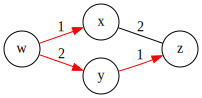

In [12]:
sptree = graphviz.Graph("Dijkstra's Link State Algorithm",
                        filename='spanning_tree',
                        graph_attr={'rankdir': 'LR'},
                        node_attr={'shape': 'circle'})

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir='forward', label=str(E[(u, v)]), color="Red") for (u, v) in path]
[sptree.edge(u, v, label=str(E[(u, v)])) for (u, v) in edges if {u, v} not in map(set, path)]

sptree